In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
#show the dataset c207 from solomon
import pandas as pd

file_path = '//kaggle/input/c207-txt/c207.txt' 

with open(file_path, 'r') as file:
    lines = file.readlines()

start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2  
        break


data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    customer = int(parts[0])
    x = float(parts[1])
    y = float(parts[2])
    demand = int(parts[3])
    ready = int(parts[4])
    due = int(parts[5])
    service = int(parts[6])
    data.append([customer, x, y, demand, ready, due, service])


columns = ["Customer", "X","Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)

df.head(20)


,Customer,X,Y,Demand,ReadyTime,DueDate,ServiceTime
0,0,40.0,50.0,0,0,3390,0
1,1,52.0,75.0,10,302,479,90
2,2,45.0,70.0,30,157,428,90
3,3,62.0,69.0,10,1138,1355,90
4,4,60.0,66.0,10,1247,1434,90
5,5,42.0,65.0,10,15,208,90
6,6,16.0,42.0,20,209,944,90
7,7,58.0,70.0,20,1059,1246,90
8,8,34.0,60.0,20,2035,3288,90
9,9,28.0,70.0,10,2090,3271,90


Best path using Nearest Neighbor + BWKA:
[93, 5, 75, 2, 1, 99, 100, 97, 95, 94, 92, 98, 7, 3, 4, 89, 91, 88, 86, 84, 83, 82, 77, 78, 81, 76, 71, 70, 73, 79, 80, 85, 87, 96, 74, 62, 66, 69, 67, 63, 61, 64, 72, 65, 68, 41, 42, 43, 47, 45, 50, 51, 52, 6, 32, 33, 34, 36, 39, 38, 37, 35, 31, 29, 27, 24, 22, 20, 21, 8, 10, 11, 9, 25, 23, 26, 28, 30, 13, 17, 18, 19, 15, 16, 14, 12, 90, 48, 46, 44, 40, 57, 55, 54, 59, 58, 56, 53, 60, 49]
Least cost (total distance): 703.97


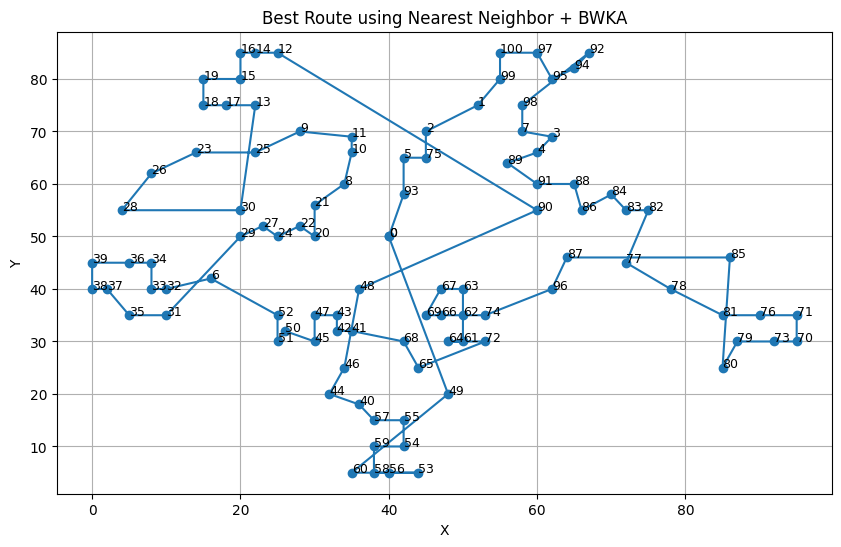

In [22]:
#Nearest Neighbor + BWKA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


file_path = '/kaggle/input/c207-txt/c207.txt'  
with open(file_path, 'r') as file:
    lines = file.readlines()


start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2
        break

data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    data.append([int(parts[0]), float(parts[1]), float(parts[2]),
                 int(parts[3]), int(parts[4]), int(parts[5]), int(parts[6])])

columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)


locations = df[["X", "Y"]].values
demands = df["Demand"].values
time_windows = df[["ReadyTime", "DueDate"]].values
service_times = df["ServiceTime"].values
vehicle_capacity = 700

def compute_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(locations)


def nearest_neighbor_route(dist_matrix, start=0):
    n = len(dist_matrix)
    unvisited = set(range(1, n))
    route = []
    current = start
    while unvisited:
        next_node = min(unvisited, key=lambda x: dist_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    return route

def initialize_population_nn(pop_size, dist_matrix):
    base_route = nearest_neighbor_route(dist_matrix)
    population = [base_route.copy() for _ in range(pop_size)]
    for i in range(1, pop_size):
        route = population[i]
        i1, i2 = np.random.choice(len(route), 2, replace=False)
        route[i1], route[i2] = route[i2], route[i1]
    return population


def evaluate_solution(route, dist_matrix):
    total_distance = 0
    prev = 0 
    for node in route:
        total_distance += dist_matrix[prev][node]
        prev = node
    total_distance += dist_matrix[prev][0] 
    return total_distance


def bwka(dist_matrix, population_size=10, iterations=100):
    population = initialize_population_nn(population_size, dist_matrix)
    best_solution = None
    best_fitness = float('inf')

    for _ in range(iterations):
        fitnesses = [evaluate_solution(route, dist_matrix) for route in population]
        min_idx = np.argmin(fitnesses)

        if fitnesses[min_idx] < best_fitness:
            best_fitness = fitnesses[min_idx]
            best_solution = population[min_idx]

       
        new_population = []
        for route in population:
            new_route = route.copy()
            i, j = np.random.choice(len(new_route), 2, replace=False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_population.append(new_route)

        population = new_population

    return best_solution, best_fitness


best_route, best_cost = bwka(distance_matrix, population_size=20, iterations=200)

print("Best path using Nearest Neighbor + BWKA:")
print(best_route)
print("Least cost (total distance):", round(best_cost, 2))


def plot_route(route, locations):
    ordered = [0] + list(route) + [0]
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]

    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=9)
    plt.title("Best Route using Nearest Neighbor + BWKA")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_route(best_route, locations)


best route BWKA: [  7  53  43  85  71  36  19  26  18  27  60  50  77   5  87  72  78   3
  70  32  31  34   1  29   9  84  13  35  25  23  52  46  17  30  62  47
  90   8  82  86  16  24  33  54   4  99  81  20 100   2  75  15  98  51
  63  97  37   6  68  39  67  76  64  42  55  65  73  79  89  38  91  92
  59  41  61  66  95  96  69  80  94  14  10  56  74  58  40  57  83  48
  11  93  49  12  22  45  44  28  88  21]
Lowest cost (dist) BWKA: 3575.05
Best route using Nearest Neighbor: [0, 93, 5, 75, 2, 1, 99, 100, 97, 95, 94, 92, 98, 7, 3, 4, 89, 91, 88, 86, 84, 83, 82, 77, 78, 81, 76, 71, 70, 73, 79, 80, 85, 87, 96, 74, 62, 66, 69, 67, 63, 61, 64, 72, 65, 68, 41, 42, 43, 47, 45, 50, 51, 52, 6, 32, 33, 34, 36, 39, 38, 37, 35, 31, 29, 27, 24, 22, 20, 21, 8, 10, 11, 9, 25, 23, 26, 28, 30, 13, 17, 18, 19, 15, 16, 14, 12, 90, 48, 46, 44, 40, 57, 55, 54, 59, 58, 56, 53, 60, 49]
Lowest cost (dist) Nearest Neighbor: 703.97


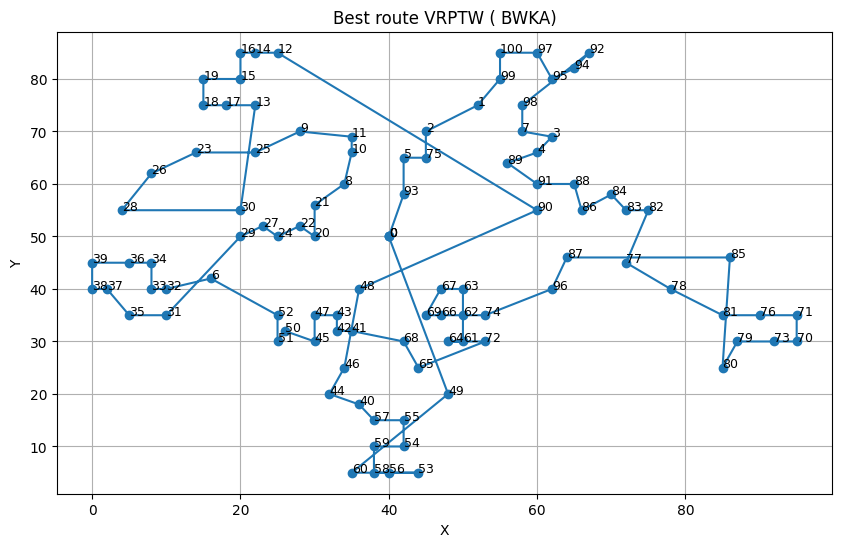

In [23]:
#Nearest Neighbor + BWKA (seprete)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


file_path = '/kaggle/input/c207-txt/c207.txt'  

with open(file_path, 'r') as file:
    lines = file.readlines()


start_index = 0
for i, line in enumerate(lines):
    if "CUSTOMER" in line:
        start_index = i + 2
        break


data = []
for line in lines[start_index:]:
    parts = line.strip().split()
    if len(parts) < 7:
        continue
    data.append([int(parts[0]), float(parts[1]), float(parts[2]),
                 int(parts[3]), int(parts[4]), int(parts[5]), int(parts[6])])

columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
df = pd.DataFrame(data, columns=columns)

locations = df[["X", "Y"]].values
demands = df["Demand"].values
time_windows = df[["ReadyTime", "DueDate"]].values
service_times = df["ServiceTime"].values
vehicle_capacity = 700
num_customers = len(df)


def compute_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_matrix[i][j] = np.linalg.norm(locations[i] - locations[j])
    return dist_matrix

distance_matrix = compute_distance_matrix(locations)

#Nearest Neighbor
def nearest_neighbor(start, dist_matrix):
    n = len(dist_matrix)
    visited = [False] * n
    route = [start] 
    visited[start] = True
    current = start
    
    while len(route) < n:
       
        nearest = None
        nearest_dist = float('inf')
        for i in range(n):
            if not visited[i] and dist_matrix[current][i] < nearest_dist:
                nearest = i
                nearest_dist = dist_matrix[current][i]
        route.append(nearest)
        visited[nearest] = True
        current = nearest
    
    return route


def initialize_population(pop_size, num_nodes):
    return [np.random.permutation(np.arange(1, num_nodes)) for _ in range(pop_size)]

def evaluate_solution(route, dist_matrix):
    total_distance = 0
    prev = 0  # depot
    for node in route:
        total_distance += dist_matrix[prev][node]
        prev = node
    total_distance += dist_matrix[prev][0] 
    return total_distance

def bwka(dist_matrix, population_size=10, iterations=100):
    population = initialize_population(population_size, len(dist_matrix))
    best_solution = None
    best_fitness = float('inf')

    for _ in range(iterations):
        fitnesses = [evaluate_solution(route, dist_matrix) for route in population]
        min_idx = np.argmin(fitnesses)

        if fitnesses[min_idx] < best_fitness:
            best_fitness = fitnesses[min_idx]
            best_solution = population[min_idx]

        
        new_population = []
        for route in population:
            new_route = route.copy()
            i, j = np.random.choice(len(new_route), 2, replace=False)
            new_route[i], new_route[j] = new_route[j], new_route[i]
            new_population.append(new_route)

        population = new_population

    return best_solution, best_fitness


best_route, best_cost = bwka(distance_matrix)


initial_route = nearest_neighbor(0, distance_matrix)
initial_cost = evaluate_solution(initial_route, distance_matrix)


print("best route BWKA:", best_route)
print("Lowest cost (dist) BWKA:", round(best_cost, 2))
print("Best route using Nearest Neighbor:", initial_route)
print("Lowest cost (dist) Nearest Neighbor:", round(initial_cost, 2))

import matplotlib.pyplot as plt

def plot_all_routes(routes, locations, title="VRPTW Routes"):
    plt.figure(figsize=(12, 8))
    cmap = plt.colormaps['tab20']  # خريطة الألوان
    N = len(routes)

    for i, route in enumerate(routes):
        ordered = [0] + route + [0]  # بداية ونهاية من الـ depot
        xs = [locations[idx][0] for idx in ordered]
        ys = [locations[idx][1] for idx in ordered]

        color = cmap(i / N)  # لون مختلف بناءً على النسبة
        plt.plot(xs, ys, marker='o', linestyle='-', color=color, label=f"Vehicle {i+1}")
        for idx in ordered:
            plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=8)

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_route(route, locations):
    ordered = [0] + list(route) + [0]
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]
    
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o')
    for i, idx in enumerate(ordered):
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=9)
    plt.title("Best route VRPTW ( BWKA)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_route(initial_route, locations)


 Simulated Annealing 
Route: [35, 44, 51, 64, 21, 30, 6, 34, 23, 26, 79, 56, 58, 55, 46, 100, 94, 10, 9, 37, 48, 63, 62, 66, 68, 11, 95, 73, 75, 19, 98, 25, 41, 52, 17, 15, 29, 87, 18, 16, 80, 85, 2, 5, 33, 49, 67, 12, 14, 74, 90, 89, 78, 70, 20, 93, 7, 4, 22, 91, 99, 13, 31, 47, 82, 69, 36, 39, 38, 57, 45, 1, 88, 83, 71, 96, 81, 76, 54, 59, 97, 92, 72, 65, 42, 43, 40, 60, 24, 28, 50, 61, 53, 77, 3, 86, 84, 8, 27, 32]
Total Distance: 2839.55


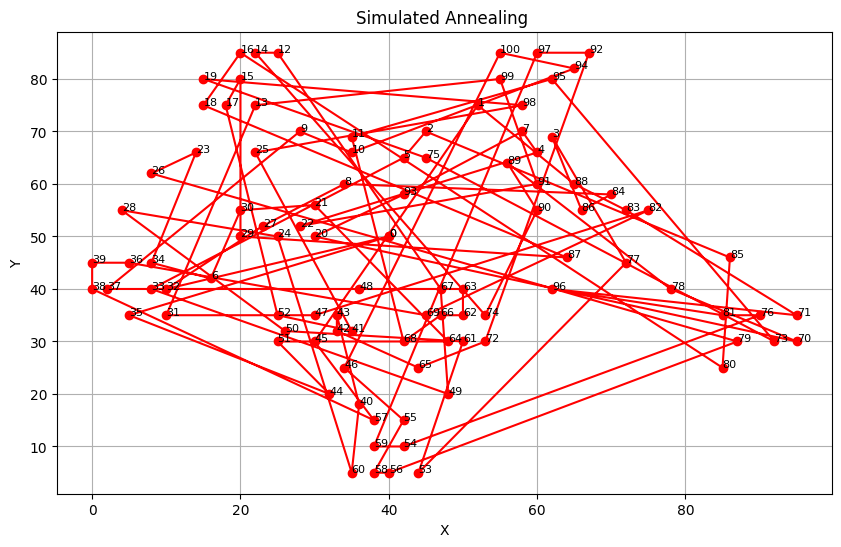

In [24]:
#Simulated Annealing 
import numpy as np
import pandas as pd

file_path = '/kaggle/input/c207-txt/c207.txt'  

with open(file_path, 'r') as file:
    lines = file.readlines()
  
df.columns = ["Customer", "X", "Y", "Demand", "ReadyTime", "DueDate", "ServiceTime"]
locations = df[["X", "Y"]].values

def compute_distance_matrix(locs):
    n = len(locs)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist[i][j] = np.linalg.norm(locs[i] - locs[j])
    return dist

distance_matrix = compute_distance_matrix(locations)

def evaluate_route(route, distance_matrix):
    cost = 0
    prev = 0
    for node in route:
        cost += distance_matrix[prev][node]
        prev = node
    cost += distance_matrix[prev][0]
    return cost

def generate_random_solution(num_customers):
    return list(np.random.permutation(range(1, num_customers)))  

def perturb(route):
    new_route = route.copy()
    i, j = np.random.choice(len(route), 2, replace=False)
    new_route[i], new_route[j] = new_route[j], new_route[i]
    return new_route

def bad_simulated_annealing(distance_matrix, num_customers, initial_temp=1000, cooling_rate=0.90, iterations=200):
    current_solution = generate_random_solution(num_customers)
    best_solution = current_solution.copy()
    current_cost = evaluate_route(current_solution, distance_matrix)
    best_cost = current_cost
    temp = initial_temp

    for _ in range(iterations):
        new_solution = perturb(current_solution)
        new_cost = evaluate_route(new_solution, distance_matrix)
        if new_cost < current_cost or np.random.rand() < np.exp((current_cost - new_cost) / temp):
            current_solution = new_solution
            current_cost = new_cost
            if new_cost < best_cost:
                best_solution = new_solution
                best_cost = new_cost
        temp *= cooling_rate 
    return best_solution, best_cost

num_customers = len(df)
bad_route, bad_cost = bad_simulated_annealing(distance_matrix, num_customers)

print(" Simulated Annealing ")
print("Route:", bad_route)
print("Total Distance:", round(bad_cost, 2))

import matplotlib.pyplot as plt

def plot_route(route, locations, title="Simulated Annealing "):
    ordered = [0] + route + [0] 
    xs = [locations[i][0] for i in ordered]
    ys = [locations[i][1] for i in ordered]

    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='-', color='red')
    for idx in ordered:
        plt.text(locations[idx][0], locations[idx][1], str(idx), fontsize=8)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

plot_route(bad_route, locations)


Iteration 0 - Best Cost: 4379.1132907081665
Iteration 1 - Best Cost: 3656.7976309804167
Iteration 2 - Best Cost: 3757.875025351265
Iteration 3 - Best Cost: 3654.103066406174
Iteration 4 - Best Cost: 3634.263063697242
Iteration 5 - Best Cost: 3473.4101391226013
Iteration 6 - Best Cost: 3776.157175698535
Iteration 7 - Best Cost: 3491.3388851912787
Iteration 8 - Best Cost: 3734.2872023897053
Iteration 9 - Best Cost: 3572.455372648642
Iteration 10 - Best Cost: 3502.6336558743787
Iteration 11 - Best Cost: 3645.775269938005
Iteration 12 - Best Cost: 3615.298145995418
Iteration 13 - Best Cost: 3583.9446559335192
Iteration 14 - Best Cost: 3711.699266592879
Iteration 15 - Best Cost: 3524.811676936551
Iteration 16 - Best Cost: 3663.9218043410533
Iteration 17 - Best Cost: 3579.088207437419
Iteration 18 - Best Cost: 3561.0071725589564
Iteration 19 - Best Cost: 3735.063859130419
Iteration 20 - Best Cost: 3660.243882581439
Iteration 21 - Best Cost: 3693.1227169228587
Iteration 22 - Best Cost: 3544.0

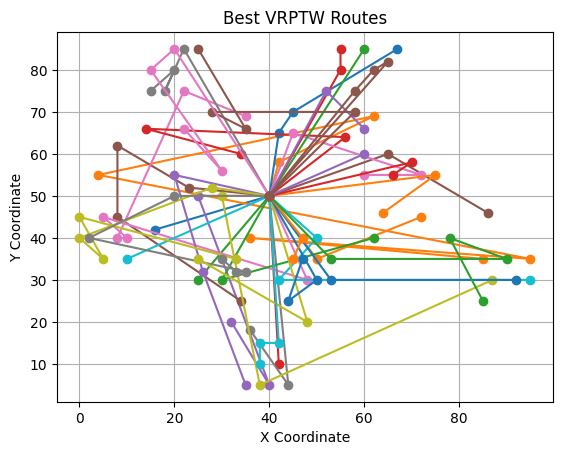

In [12]:
#Gray wolf algorithm
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


def load_vrptw_data(path='/kaggle/input/c207-txt-right-one/C207 (3).csv'):
    df = pd.read_csv(path)

    df.columns = [col.strip().upper() for col in df.columns]
    rename_map = {
        'CUST NO.': 'id',
        'XCOORD.': 'x',
        'YCOORD.': 'y',
        'DEMAND': 'demand',
        'READY TIME': 'ready_time',
        'DUE DATE': 'due_date',
        'SERVICE TIME': 'service_time',
        'SERVICE TI': 'service_time'
    }
    df.rename(columns=rename_map, inplace=True)

    return df.to_dict('records')


def euclidean_distance(x1, y1, x2, y2):
    return math.hypot(x2 - x1, y2 - y1)


def evaluate_solution(solution, customers, vehicle_capacity=700):
    total_distance = 0
    time = 0
    load = 0
    current_customer = customers[0]  
    route = [[0]]  

    for idx in solution:
        customer = customers[idx]
        travel_time = euclidean_distance(current_customer['x'], current_customer['y'], customer['x'], customer['y'])
        arrival_time = time + travel_time

        if (load + customer['demand'] > vehicle_capacity or arrival_time > customer['due_date']):
            total_distance += euclidean_distance(current_customer['x'], current_customer['y'],
                                                 customers[0]['x'], customers[0]['y'])
            time = 0
            load = 0
            current_customer = customers[0]
            route.append([0])
            travel_time = euclidean_distance(current_customer['x'], current_customer['y'], customer['x'], customer['y'])
            arrival_time = time + travel_time

        time = max(arrival_time, customer['ready_time']) + customer['service_time']
        load += customer['demand']
        total_distance += travel_time
        route[-1].append(idx)
        current_customer = customer

    total_distance += euclidean_distance(current_customer['x'], current_customer['y'], customers[0]['x'], customers[0]['y'])
    route[-1].append(0)
    return total_distance, route


def initial_position_vrptw(pack_size, customer_size, target_function, customers):
    position = []
    for _ in range(pack_size):
        sol = list(np.random.permutation(range(1, customer_size)))
        cost, _ = target_function(sol, customers)
        position.append(sol + [cost])
    return np.array(position, dtype=object)


def update_position_vrptw(position, alpha, beta, delta, a_linear_component, target_function, customers):
    updated_position = []
    n = len(alpha)

    for pos in position:
        wolf = pos[:-1]
        new_wolf = wolf.copy()

        for i in range(n):
            r1, r2 = np.random.rand(), np.random.rand()
            A1 = 2 * a_linear_component * r1 - a_linear_component
            C1 = 2 * r2
            D_alpha = abs(C1 * alpha[i] - wolf[i])
            x1 = int(abs(alpha[i] - A1 * D_alpha)) % n + 1

            r1, r2 = np.random.rand(), np.random.rand()
            A2 = 2 * a_linear_component * r1 - a_linear_component
            C2 = 2 * r2
            D_beta = abs(C2 * beta[i] - wolf[i])
            x2 = int(abs(beta[i] - A2 * D_beta)) % n + 1

            r1, r2 = np.random.rand(), np.random.rand()
            A3 = 2 * a_linear_component * r1 - a_linear_component
            C3 = 2 * r2
            D_delta = abs(C3 * delta[i] - wolf[i])
            x3 = int(abs(delta[i] - A3 * D_delta)) % n + 1

            new_wolf[i] = [x1, x2, x3][np.random.randint(0, 3)]

        seen = set()
        new_solution = []
        for val in new_wolf:
            if val not in seen and 1 <= val < len(customers):
                new_solution.append(val)
                seen.add(val)

        # أضف القيم المفقودة
        for i in range(1, len(customers)):
            if i not in seen:
                new_solution.append(i)

        cost, _ = target_function(new_solution, customers)
        updated_position.append(new_solution + [cost])

    return np.array(updated_position, dtype=object)


# GWO Main
def grey_wolf_optimizer_vrptw(pack_size, customers, iterations, target_function):
    customer_size = len(customers)
    position = initial_position_vrptw(pack_size, customer_size, target_function, customers)
    alpha = min(position, key=lambda x: x[-1])
    beta = sorted(position, key=lambda x: x[-1])[1]
    delta = sorted(position, key=lambda x: x[-1])[2]

    for t in range(iterations):
        print(f"Iteration {t} - Best Cost: {alpha[-1]}")
        a = 2 - t * (2 / iterations)
        position = update_position_vrptw(position, alpha[:-1], beta[:-1], delta[:-1], a, target_function, customers)
        sorted_pack = sorted(position, key=lambda x: x[-1])
        alpha, beta, delta = sorted_pack[0], sorted_pack[1], sorted_pack[2]

    return alpha


def plot_routes(routes, customers):
    for route in routes:
        x = [customers[i]['x'] for i in route]
        y = [customers[i]['y'] for i in route]
        plt.plot(x, y, marker='o')
    plt.title('Best VRPTW Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    customers = load_vrptw_data('/kaggle/input/c207-txt-right-one/C207 (3).csv')
    best_solution = grey_wolf_optimizer_vrptw(
        pack_size=30,
        customers=customers,
        iterations=100,
        target_function=evaluate_solution
    )

    print("\nBest Routes:", best_solution[:-1])
    print("\nLowest cost(dist):", best_solution[-1])
    _, routes = evaluate_solution(best_solution[:-1], customers)
    plot_routes(routes, customers)
